# Analysis description

The following scripts parametrise resting state EEG data.

 - `01_load_data.py` Load data into `xarray` array
 - `02_compute_params.py` Compute spectrum, estimate parameters and save into intermediate file.
 
 There is alternative script `02_compute_spectrum.py` that computes the spectrum only.

To run these scripts from the notebook, the line magic `%run` is used.
Putting `%%script false --no-raise-error` at the top of the cell are preventing this cell from running (as the values are already computes).


In [ ]:
%%script false --no-raise-error
%cd '/Users/daniel/PhD/Projects/ephys-poirot-analysis/studies/MEG_ASSR_RS'
!python '01_load_data.py'
!python '02_compute_params.py'

# Visualise computed spectrum

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

<xarray.DataArray (regions: 14, freqs: 1201)>
array([[8.31883360e-25, 3.18676984e-25, 5.89084945e-25, ...,
        3.02064142e-36, 3.32312352e-36, 1.93999189e-36],
       [5.02838086e-25, 1.83144861e-25, 8.20576866e-25, ...,
        3.02452050e-36, 3.58022455e-36, 2.22795288e-36],
       [3.22921000e-24, 1.20640400e-24, 2.59025109e-24, ...,
        9.19044154e-36, 1.06787582e-35, 6.13015470e-36],
       ...,
       [4.28880897e-25, 1.59208956e-25, 3.34267139e-25, ...,
        1.10817307e-36, 1.24750876e-36, 6.73555039e-37],
       [1.26374111e-24, 4.34774285e-25, 3.34066840e-24, ...,
        1.21854667e-35, 1.31096513e-35, 7.31559154e-36],
       [2.56037387e-24, 9.15355255e-25, 4.16748258e-24, ...,
        8.89854076e-36, 1.05245068e-35, 6.03693384e-36]])
Coordinates:
  * freqs    (freqs) float64 0.0 0.25 0.5 0.75 1.0 ... 299.2 299.5 299.8 300.0
  * regions  (regions) object 'LC' 'LF' 'LL' 'LO' 'LP' ... 'RO' 'RP' 'RPF' 'RT'

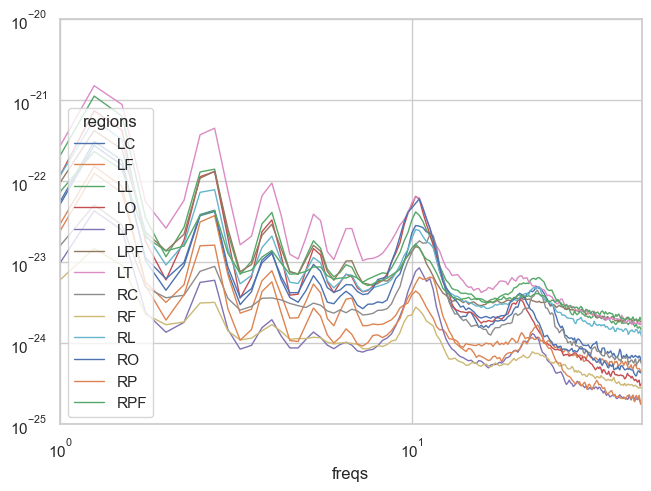

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"

da = xr.open_dataarray(f"{DATA_FOLDER}/interim/power/S010_MEG_ASSR_power.nc")
da.close()
fig, ax = plt.subplots(layout='constrained')

y = (
    da
    .mean("trial")
    .mean("iter_number")
    .mean("session")
    .mean("sub")
    .groupby("regions")
    .mean("labels")
)
display(y)
(y
 .isel(regions=slice(0, 13))
 .plot.line(
    x="freqs", xlim=[1, 45], ylim = [10e-26, 10e-21 ],yscale='log', xscale='log', linewidth=1.0)
 ) # type: ignore
# fig.legend(loc='outside right upper')
plt.show()


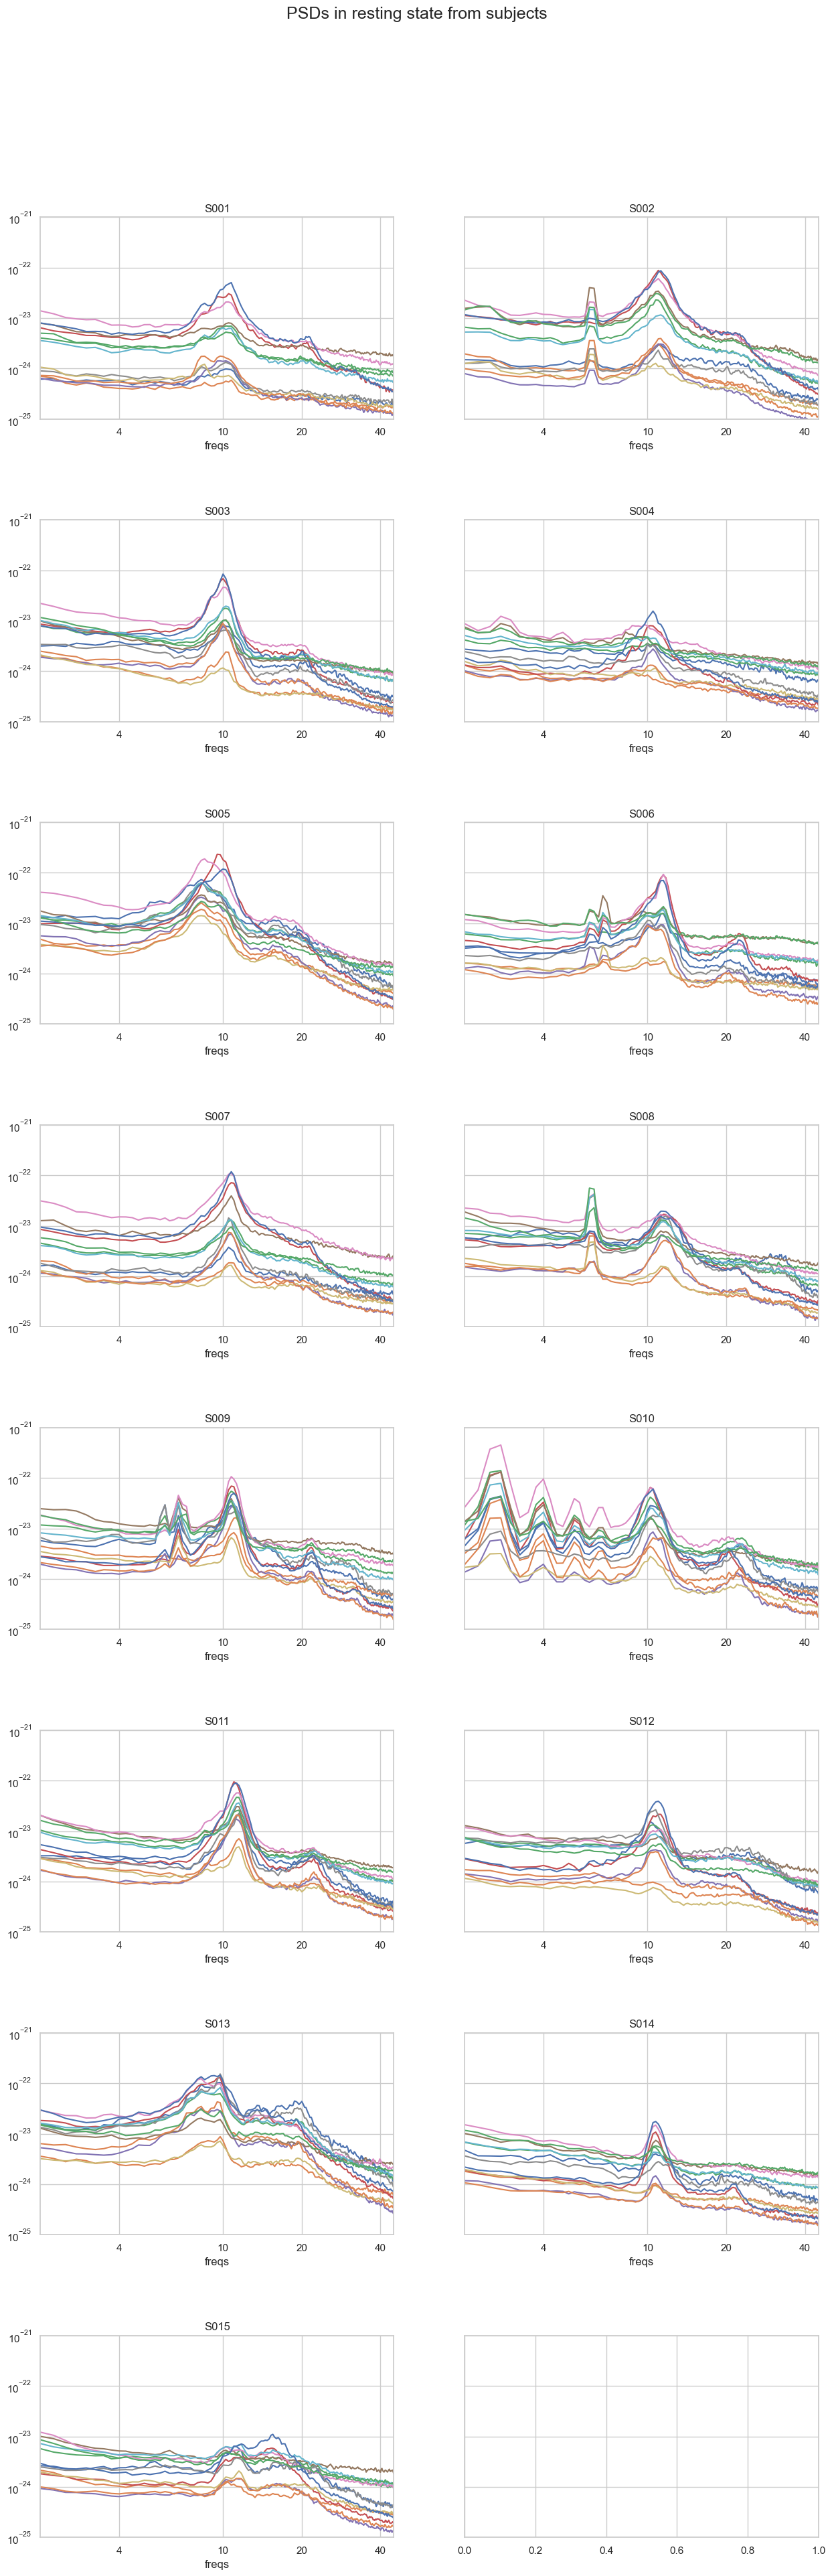

In [3]:
import seaborn as sns
import matplotlib

sns.set_theme(style="whitegrid")

DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"
SUBS = ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 
        'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015']

SUB = 'S001'
def plot_subjects(DATA_FOLDER, SUB,ax):
    da = xr.open_dataarray(f"{DATA_FOLDER}/interim/power/{SUB}_MEG_ASSR_power.nc")
    da.close()
    (
        da
        .mean("trial")
        .mean("iter_number")
        .mean("session")
        .mean("sub")
        .groupby("regions")
        .mean("labels")
        .isel(regions=slice(0, 13))
        .plot.line(
            x="freqs",  xlim=[2, 45],  ylim = [10e-26, 10e-22 ], yscale='log', xscale='log', ax=ax)
        ) # type: ignore


fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(15, 45),  sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("PSDs in resting state from subjects", fontsize=18, y=0.95)
for SUB, ax in zip(SUBS, axs.ravel()):
#for SUB in SUBS:
    plot_subjects(DATA_FOLDER, SUB,ax)
    ax.set_title(SUB)
    ax.get_legend().remove()
    ax.set_xticks([ 4, 10, 20, 40])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #plt.title(SUB)
plt.show()
fig.savefig("overview_psds", dpi=300, bbox_inches='tight')


# Analysis of the `specparam` parameters

- [ ] First step will be to filter data to remove information about CF (we don't need it now)

Example description.

The `specparam` algorithm (version 1.0.0) was used to parametrise power spectra. Algorithm settings were set as: peak width limits: [2.5 8]; max number of peaks: 6; minimum peak height: 0.5; peak threshold: 2; and aperiodic mode: ‘fixed’,. Power spectra were parametrised across the frequency range 3 to 48 Hz.

 The `specparam` algorithm was used to parametrise the PSDs of ROIs. Then the parameters describing the EEG were averaged across all  regions contained within parietal region to create one describing the offset and exponent variables for participant (except for alpha peak frequency, where first the fits having highest value of power PW were chosen within region of interest, the rest of values were discarded, and then different parietal regions of interest were averaged)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import tqdm as tqdm
from fooof import  FOOOFGroup

from poirot.spectrum import  specparam_attributes, my_compute_spectrum

DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"

def process_spectrum(ds, stacked_cols, fg, freq_range):
    return (
        xr.apply_ufunc(
            my_compute_spectrum, ds, 
            vectorize=True,
            input_core_dims=[['time']],
            output_core_dims=[['freqs']],
            kwargs = {"fs" :fs, "nperseg":4*fs})
        .assign_coords(freqs = lambda x: np.linspace(0,fs/2, len(x.freqs)))
        .mean("trial")
        .mean("iter_number")
        .pipe(
            specparam_attributes,
            stacked_cols=stacked_cols,
            fg=fg,
            freq_range=freq_range,
        )
    )

SUBS = ['S001']

sessions = ["Session1", "Session2"]

fs = 600

fg = FOOOFGroup(
    peak_width_limits=[2, 8],
    min_peak_height=0.1,
    max_n_peaks=12,
)

freq_range = [2, 40]

stacked_cols = ['labels','sub','session']

for subject in SUBS:
        ds = xr.open_dataarray(f"{DATA_FOLDER }/interim/timeseries/{subject}_MEG_ASSR_times.nc")
        ds.close()
        df = (
        process_spectrum(ds, stacked_cols, fg, freq_range)
        .drop(['CF', 'PW', "BW"], axis=1)
        .drop_duplicates()
        )
        display(df)

Running FOOOFGroup: 100%|██████████| 136/136 [00:02<00:00, 56.75it/s]


,labels,sub,session,regions,offset,exponent,error,r_squared
0,bankssts L,S001,Session1,LT,-23.379191,0.851898,0.034009,0.985167
7,bankssts L,S001,Session2,LT,-23.243897,0.897257,0.036616,0.984142
15,bankssts R,S001,Session1,RT,-22.697404,1.024691,0.056335,0.975966
18,bankssts R,S001,Session2,RT,-23.173078,0.894421,0.045428,0.977465
21,caudalanteriorcingulate L,S001,Session1,LL,-23.415019,0.402003,0.032840,0.958955
...,...,...,...,...,...,...,...,...
550,temporalpole R,S001,Session2,RT,-21.630059,0.863917,0.041623,0.977425
555,transversetemporal L,S001,Session1,LT,-22.886564,0.630857,0.035158,0.971156
559,transversetemporal L,S001,Session2,LT,-22.598482,0.785864,0.041038,0.980689
565,transversetemporal R,S001,Session1,RT,-22.015955,0.859427,0.042299,0.979014


In [29]:

df = pd.read_hdf('MEG_ASSR_specparams.h5', key='specparam')
df.head()

df_filtered = (
    df
    .drop(['CF', 'PW', "BW"], axis=1)
    .drop_duplicates()
)
df.to_csv("specparms.csv")
df.head()

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

In [ ]:
df

# Load example data and plot it on Desikan-Killyany atlas

## Specific parcelation

The parcelation that was use is Desikan-Killiany atlas (Destrieux et al., 2010) with 68 regions. The atlas was obtained from `nilearn` package (Abraham et al., 2014). 

```{r} 
[python-ggseg/ggseg.ipynb at main · danieltomasz/python-ggseg · GitHub](https://github.com/danieltomasz/python-ggseg/blob/main/doc/ggseg.ipynb)